# Hyperband training for our deep learning model

The hyperband algorithm randomly generates a set of configurations of hyperparameters and then tests them with some model on a given dataset. Initially, the tests are computed using very few iterations. The best performing 50% of the configurations are kept and the other 50% are resampled from the space of hyperparameters (successive halving).


In [1]:
import argparse
import os
import sys
from PIL import Image, ImageOps
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.init as init
from torchvision import transforms, utils
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
import pickle
from collections import OrderedDict
import math
from IPython.display import Image

# Custom generator for our dataset
from modules.dataset import PileupDataset, TextColor

## Implementation of Hyperband, modified for python3. Copied from [here](https://github.com/elPistolero/hyperband_pytorch_example/blob/master/Hyperband%20Tutorial%20for%20PyTorch.ipynb)

In [2]:
from __future__ import print_function

import numpy as np

from random import random
from math import log, ceil
from time import time, ctime


class Hyperband:
    
    def __init__( self, get_params_function, try_params_function ):
        self.get_params = get_params_function
        self.try_params = try_params_function
        
        self.max_iter = 20      # maximum iterations per configuration
        self.eta = 3            # defines configuration downsampling rate (default = 3)

        self.logeta = lambda x: log( x ) / log( self.eta )
        self.s_max = int( self.logeta( self.max_iter ))
        self.B = ( self.s_max + 1 ) * self.max_iter

        self.results = []    # list of dicts
        self.counter = 0
        self.best_loss = np.inf
        self.best_counter = -1
        

    # can be called multiple times
    def run( self, skip_last = 0, dry_run = False ):
        
        for s in reversed( range( self.s_max + 1 )):
            
            # initial number of configurations
            n = int( ceil( self.B / self.max_iter / ( s + 1 ) * self.eta ** s ))    
            
            # initial number of iterations per config
            r = self.max_iter * self.eta ** ( -s )        

            # n random configurations
            T = [ self.get_params() for i in range( n )] 
            
            for i in range(( s + 1 ) - int( skip_last )):    # changed from s + 1
                
                # Run each of the n configs for <iterations> 
                # and keep best (n_configs / eta) configurations
                
                n_configs = n * self.eta ** ( -i )
                n_iterations = r * self.eta ** ( i )
                
                print("\n*** {} configurations x {:.1f} iterations each".format( n_configs, n_iterations ))
                
                val_losses = []
                early_stops = []
                
                for t in T:
                    
                    self.counter += 1
                    print("\n{} | {} | lowest loss so far: {:.4f} (run {})\n".format( self.counter, ctime(), self.best_loss, self.best_counter ))
                    
                    start_time = time()
                    
                    if dry_run:
                        result = { 'loss': random(), 'log_loss': random(), 'auc': random()}
                    else:
                        result = self.try_params( n_iterations, t )        # <---
                        
                    assert( type( result ) == dict )
                    assert( 'loss' in result )
                    
                    seconds = int( round( time() - start_time ))
                    print("\n{} seconds.".format( seconds))
                    
                    loss = result['loss']    
                    val_losses.append( loss )
                    
                    early_stop = result.get( 'early_stop', False )
                    early_stops.append( early_stop )
                    
                    # keeping track of the best result so far (for display only)
                    # could do it be checking results each time, but hey
                    if loss < self.best_loss:
                        self.best_loss = loss
                        self.best_counter = self.counter
                    
                    result['counter'] = self.counter
                    result['seconds'] = seconds
                    result['params'] = t
                    result['iterations'] = n_iterations
                    
                    self.results.append( result )
                
                # select a number of best configurations for the next loop
                # filter out early stops, if any
                indices = np.argsort( val_losses )
                T = [ T[i] for i in indices if not early_stops[i]]
                T = T[ 0:int( n_configs / self.eta )]
        
        return self.results

## The network- Wide Residual Networks
### Re-implemented to fit our problem space
Deep residual networks were shown to be able to scale up to thousands of layers and still have improving performance. However, each fraction of a percent of improved accuracy costs nearly doubling the number of layers, and so training very deep residual networks has a problem of diminishing feature reuse, which makes these networks very slow to train.

To tackle these problems, in this work we conduct a detailed experimental study on the architecture of ResNet blocks, based on which we propose a novel architecture where we decrease depth and increase width of residual networks. We call the resulting network structures wide residual networks (WRNs) and show that these are far superior over their commonly used thin and very deep counterparts.

### Define a block of the neural network
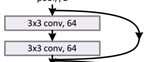

In [3]:
# Single block defining a single cell in the network
class SingleBlock(nn.Module):
    '''
    Structure of a single block/cell in a layer. Consider this as a single neuron of the network.
    '''
    def __init__(self, in_channels, out_channels, stride, drop_rate=0.0):
        '''
        Initialize a single cell.
        '''
        super(SingleBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.drop_rate = drop_rate
        self.equalInOut = (in_channels == out_channels)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None

    def forward(self, x):
        '''
        Perform all caluclations that happen in a single cell block.
        '''
        if not self.equalInOut:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.drop_rate > 0:
            out = F.dropout(out, p=self.drop_rate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

### Define a layer of the network
A layer consists of multiple blocks
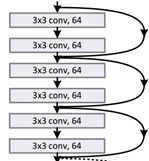

In [4]:
class LayerBlock(nn.Module):
    '''
    Structure of layer of the neural network. A layer would contain N number of blocks.
    '''
    def __init__(self, nb_layers, in_channels, out_channels, block, stride, drop_rate=0.0):
        '''
        Initialize a layer. Block is a cell represented as an object of SingleBlock class
        '''
        super(LayerBlock, self).__init__()
        self.layer = self._make_layer(block, in_channels, out_channels, nb_layers, stride, drop_rate)

    def _make_layer(self, block, in_channels, out_channels, nb_layers, stride, drop_rate):
        '''
        '''
        layers = []
        for i in range(nb_layers):
            layers.append(block(i == 0 and in_channels or out_channels, out_channels, i == 0 and stride or 1, drop_rate))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layer(x)

### Define the network
Define the whole network that we need to use
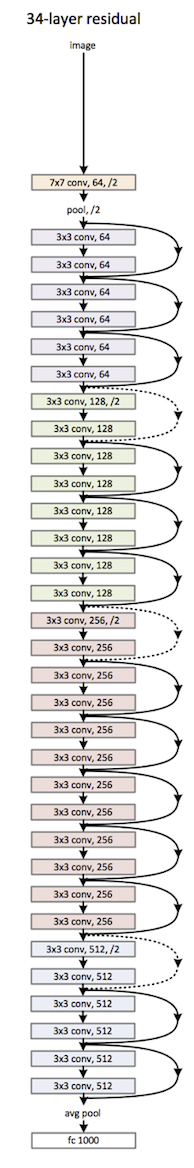

In [5]:
class Model(nn.Module):
    '''
    The model itself. It's a three block model with variable depth and widen factor.
    '''
    def __init__(self, input_channels, depth, num_classes, widen_factor, drop_rate):
        super(Model, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = int((depth - 4) / 6)
        block = SingleBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(input_channels, nChannels[0], kernel_size=(1, 15), stride=1,
                               padding=(0, 7), bias=False)
        self.conv2 = nn.Conv2d(nChannels[0], nChannels[0], kernel_size=(3, 3), stride=1,
                               padding=(1, 1), bias=False)
        # 1st block
        self.block1 = LayerBlock(n, nChannels[0], nChannels[1], block, 1, drop_rate)
        # 2nd block
        self.block2 = LayerBlock(n, nChannels[1], nChannels[2], block, (1, 2), drop_rate)
        # 3rd block
        self.block3 = LayerBlock(n, nChannels[2], nChannels[3], block, (1, 2), drop_rate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3] * 19, num_classes)
        self.nChannels = nChannels[3]
        self.num_classes = num_classes

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(2)
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, (1, 2))
        out = out.view(batch_size, seq_len, -1)
        out = self.fc(out)
        return out

## Train the model

Train the model with this method

In [6]:
def train(train_file, depth, widen_factor, drop_rate, batch_size, epoch_limit, learning_rate, l2, debug_mode, gpu_mode, seq_len, iteration_jump, num_classes):
    
    # Convert the image to tensor
    transformations = transforms.Compose([transforms.ToTensor()])
    
    
    if debug_mode:
        sys.stderr.write(TextColor.PURPLE + 'Loading data\n' + TextColor.END)
    # Load training data
    train_data_set = PileupDataset(train_file, transformations)
    train_loader = DataLoader(train_data_set,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=16,
                              pin_memory=gpu_mode
                              )
    if debug_mode:
        sys.stderr.write(TextColor.PURPLE + 'Data loading finished\n' + TextColor.END)
    

    # Create the model to train
    input_channels = 3
    model = Model(input_channels, depth, num_classes, widen_factor, drop_rate)
    if gpu_mode:
        model = torch.nn.DataParallel(model).cuda()

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2)

    # Train the Model
    if debug_mode:
        sys.stderr.write(TextColor.PURPLE + 'Training starting\n' + TextColor.END)
    
    total_loss = 0
    total_images = 0
    
    for epoch in range(epoch_limit):
        
        for i, (images, labels) in enumerate(train_loader):
            # If batch size not distributable among all GPUs then skip
            if gpu_mode is True and images.size(0) % 8 != 0:
                continue
                
            # Take images and labels of batch_size to train
            images = Variable(images, requires_grad=False)
            labels = Variable(labels, requires_grad=False)
            if gpu_mode:
                images = images.cuda()
                labels = labels.cuda()
                
            # Go through the window size of the image
            for row in range(0, images.size(2), iteration_jump):
                # Segmentation of image to window size. Currently using seq_len
                if row+seq_len > images.size(2):
                    continue

                x = images[:, :, row:row+seq_len, :]
                y = labels[:, row:row + seq_len]
                
                # Subsampling step, if there's less evidence of training on het, hom-alt then don't train
                total_variation = torch.sum(y.eq(2)).data[0]
                total_variation += torch.sum(y.eq(3)).data[0]

                if total_variation == 0 and np.random.uniform(0, 1)*100 > 5:
                    continue
                elif np.random.uniform(0, 1) < total_variation/batch_size < 0.02:
                    continue

                # Forward + Backward + Optimize
                optimizer.zero_grad()
                outputs = model(x)

                loss = criterion(outputs.contiguous().view(-1, 4), y.contiguous().view(-1))
                loss.backward()
                optimizer.step()
                
                # Add up loss and total trianing set
                total_loss += loss.data[0]
                total_images += (x.size(0)*seq_len)
                
            if debug_mode:
                sys.stderr.write(TextColor.BLUE + "EPOCH: " + str(epoch) + " Batches done: " + str(i+1))
                sys.stderr.write(" Loss: " + str(total_loss/total_images) + "\n" + TextColor.END)
                # print(str(epoch) + "\t" + str(i + 1) + "\t" + str(total_loss/total_images))

        # After each epoch print loss and save model if debug mode is on
        if debug_mode:
            sys.stderr.write(TextColor.YELLOW + 'EPOCH: ' + str(epoch))
            sys.stderr.write(' Loss: ' + str(total_loss/total_images) + "\n" + TextColor.END)
    
    if debug_mode:
        sys.stderr.write(TextColor.PURPLE + 'Finished training\n' + TextColor.END)
    
    return model
    

In [7]:
def save_model(model, file_name):
    '''
    Not used in hyperband, but this method saves trained models on disk.
    '''
    torch.save(model, file_name+'_final.pkl')

    sys.stderr.write(TextColor.PURPLE + 'Model saved as:' + file_name + '.pkl\n' + TextColor.END)
    torch.save(model.state_dict(), file_name+'_final_params'+'.pkl')

    sys.stderr.write(TextColor.PURPLE + 'Model parameters saved as:' + file_name + '-params.pkl\n' + TextColor.END)

## Test
Test a trained model. Return test loss and accuracy.

In [8]:
def most_common(lst):
    return max(set(lst), key=lst.count)

def test(model, test_file, batch_size, num_classes, gpu_mode, seq_len, debug_mode):
    # Convert the image to tensor
    transformations = transforms.Compose([transforms.ToTensor()])
    
    if debug_mode:
        sys.stderr.write(TextColor.PURPLE + 'Loading data\n' + TextColor.END)
        
    #Load the dataset
    test_dataset = PileupDataset(test_file, transformations)
    testloader = DataLoader(test_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=16,
                            pin_memory=gpu_mode # CUDA only
                            )
    
    if debug_mode:
        sys.stderr.write(TextColor.PURPLE + 'Data loading finished\n' + TextColor.END)

    if gpu_mode:
        model = model.cuda()
    
    # Loss function
    criterion = nn.CrossEntropyLoss()
    
    # Change model to 'eval' mode (BN uses moving mean/var).
    model.eval()  

    # Create a confusion tensor for evaluation
    confusion_tensor = torch.zeros(num_classes, num_classes)
    test_loss = 0
    total_datapoint = 0
    # Start testing the model
    for counter, (images, labels) in enumerate(testloader):
        
        # Load images and labels
        images = Variable(images, volatile=True)
        pl = labels
        if gpu_mode:
            images = images.cuda()
        window = 1
        
        # We take vote between all predicted classes for a base, prediction_stack keeps track of the vote
        prediction_stack = []
        
        # Per sequence window
        for row in range(0, images.size(2), 1):
            
            # For now, don't thinking about trailing bases, they are always almost 0s
            if row + seq_len > images.size(2):
                continue
                
            
            x = images[:, :, row:row + seq_len, :]
            ypl = pl[:, row]
            
            # Get prediction in probability
            preds = model(x)
            labels = Variable(pl[:, row:row+seq_len], volatile=True)
            
            # Calculate the loss and keep track of it
            loss = criterion(preds.contiguous().view(-1, num_classes), labels.contiguous().view(-1))
            test_loss += loss.data[0]
            total_datapoint += (seq_len * images.size(0))
            
            # Convert probability to class
            preds = preds.data.topk(1)[1]
            
            # Append the generated prediction to stack so we can vote
            prediction_stack.append(preds)
            
            # If we are at a position which is higher than window size then we can vote and predict
            if row+1 >= seq_len:
                # Go through each object in the stack
                for i in range(images.size(0)):
                    pr = []
                    k = seq_len - 1
                    # Collect all the votes
                    for j in range(len(prediction_stack)):
                        pr.append(prediction_stack[j][i][k][0])
                        k-=1
                    # The most frequent class wins and is the predicted class
                    p = most_common(pr)
                    # Get the target class
                    t = ypl[i]
                    # Update confusion tensor between target and predicted class
                    confusion_tensor[t][p] += 1
                    
                # After we are done pop the top most vote cause we don't need that anymore
                prediction_stack.pop(0)
        #if debug_mode:
            #print(confusion_tensor)
    
    correctly_predicted = torch.sum(confusion_tensor.diag())
    total_datapoints = torch.sum(confusion_tensor)
    accuracy = 100 * correctly_predicted / total_datapoints
    total_test_loss = test_loss / total_datapoint
    
    if debug_mode:
        print(confusion_tensor)
    
    return {'loss': total_test_loss, 'accuracy': accuracy}

## The hyperparameter space

First, we have to define the hyperparameter space, i.e. which hyperparameters are we interested in and how should they be sampled. We use hyperopt to define the search space.

For our model, the parameters we are trying to learn: <br>
1) Depth <br>
2) Widen_factor <br>
3) Batch_size <br>
4) Drop_rate <br>
5) Learning_rate <br>

In [9]:
# Paramters of the model
# depth=28 widen_factor=4 drop_rate=0.0
space = {
    'depth': hp.choice('depth', (10, 16)),
    'widen_factor': hp.choice('widen_factor', (1, 2)),
    'batch_size': hp.choice('batch_size', (5, 10)),
    'dropout_rate': hp.quniform('dropout', 0, 0.5, 0.1),
    'learning_rate': hp.loguniform('lr', -10, -2),
    'l2': hp.loguniform('l2', -10, -2),
}

### Get Parameter Method

The first method we need to design for using hyperband is the get_parameter() method. This method returns parameters from sample space.

In [10]:
def get_params():
    return sample(space)

### Try Parameter Method

The other method we need to design for hyperband is try_parameter(). In this method we try the parameter on the model we designed.

In [11]:
# Environment parameter, these parameters do not change learning or are fixed
debug_mode = False
gpu_mode = False
num_classes=4
train_file = "~/Kishwar/pileup-output/toy_data/chr3/train.csv"
test_file = "~/Kishwar/pileup-output/toy_data/chr3/test.csv"

# Few parameters are left out but can be tested
seq_len = 3
iteration_jump = 1

def try_params(n_iterations, params):
    # Number of iterations or epoch for the model to train on
    n_iterations = int(round(n_iterations))
    print("iterations: ", n_iterations)
    print("params: ", params)
    
    
    depth = params['depth']
    widen_factor = params['widen_factor']
    drop_rate = params['dropout_rate']
    batch_size = params['batch_size']
    epoch_limit = n_iterations
    learning_rate = params['learning_rate']
    l2 = params['l2']
    
    print('Training Model')
    model = train(train_file, depth, widen_factor, drop_rate, batch_size, epoch_limit, learning_rate, l2, debug_mode, gpu_mode, seq_len, iteration_jump, num_classes)
    print('Testing Model')
    stats_dictionary = test(model, test_file, batch_size, num_classes, gpu_mode, seq_len, debug_mode)
    print('Iteration Complete')
    return stats_dictionary

In [12]:
hyperband = Hyperband(get_params, try_params)
results = hyperband.run()

# Save results
save_output = False

if save_output:
    with open('results.pkl', 'wb') as f:
        pickle.dump(results, f)

# Print top 5 configs based on loss
sorted(results, key=lambda r: r['loss'])[:5]


*** 9 configurations x 2.2 iterations each

1 | Fri Nov 17 19:31:43 2017 | lowest loss so far: inf (run -1)

iterations:  2
params:  {'widen_factor': 1, 'l2': 0.0036026389011946797, 'dropout_rate': 0.1, 'depth': 10, 'batch_size': 10, 'learning_rate': 0.003408176031617785}
Training Model
Testing Model
Iteration Complete

14 seconds.

2 | Fri Nov 17 19:31:57 2017 | lowest loss so far: 0.0130 (run 1)

iterations:  2
params:  {'widen_factor': 2, 'l2': 0.003714980431311364, 'dropout_rate': 0.4, 'depth': 16, 'batch_size': 10, 'learning_rate': 0.024998937885754857}
Training Model
Testing Model
Iteration Complete

53 seconds.

3 | Fri Nov 17 19:32:50 2017 | lowest loss so far: 0.0113 (run 2)

iterations:  2
params:  {'widen_factor': 2, 'l2': 4.609988632377963e-05, 'dropout_rate': 0.4, 'depth': 16, 'batch_size': 5, 'learning_rate': 0.004913105160071381}
Training Model
Testing Model
Iteration Complete

46 seconds.

4 | Fri Nov 17 19:33:36 2017 | lowest loss so far: 0.0113 (run 2)

iterations:  

[{'accuracy': 99.1891891891892,
  'counter': 13,
  'iterations': 20.0,
  'loss': 0.0058840642806297005,
  'params': {'batch_size': 10,
   'depth': 16,
   'dropout_rate': 0.4,
   'l2': 0.003714980431311364,
   'learning_rate': 0.024998937885754857,
   'widen_factor': 2},
  'seconds': 349},
 {'accuracy': 99.39189189189189,
  'counter': 21,
  'iterations': 20,
  'loss': 0.008844977163965158,
  'params': {'batch_size': 5,
   'depth': 10,
   'dropout_rate': 0.2,
   'l2': 0.00043305820460229675,
   'learning_rate': 0.03145011737900534,
   'widen_factor': 2},
  'seconds': 135},
 {'accuracy': 98.69932432432432,
  'counter': 10,
  'iterations': 6.666666666666667,
  'loss': 0.008942629278966257,
  'params': {'batch_size': 10,
   'depth': 16,
   'dropout_rate': 0.4,
   'l2': 0.003714980431311364,
   'learning_rate': 0.024998937885754857,
   'widen_factor': 2},
  'seconds': 125},
 {'accuracy': 99.22297297297297,
  'counter': 11,
  'iterations': 6.666666666666667,
  'loss': 0.010826967217020518,
  